In [1]:
from llm_from_papers.models import GPT2Model
import torch
import tiktoken

In [2]:
config = {
    "vocab_size": 50257,
    "context_size": 256,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 12,
    "dropout": 0.1,
    "qkv_bias": False,
}

torch.manual_seed(42)
model = GPT2Model(config)
model.eval()

GPT2Model(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(256, 768)
  (dropout_embed): Dropout(p=0.1, inplace=False)
  (transfomer_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAtt

In [3]:
def genrate_simple_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # (bz, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (bz, vocab_size)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bz, 1)
        idx = torch.cat((idx, idx_next), dim=1)  # (bz
    return idx

In [4]:
def text_to_tokens(text, enc):
    tokens = enc.encode(text, allowed_special={"<|endoftext|>"})
    return torch.tensor(tokens, dtype=torch.long).unsqueeze(0)  # (1, seq_len)

def tokens_to_text(tokens, enc):
    tokens = tokens.squeeze().tolist()
    return enc.decode(tokens)

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

tokens = genrate_simple_text(
    model,
    text_to_tokens(start_context, tokenizer),
    max_new_tokens=10,
    context_size=config["context_size"],
)

print(tokens_to_text(tokens, tokenizer))

Every effort moves youodonuyomiassin Basic batted JavierPandottestriver Pearce


In [5]:
input1 = "every effort moves"
input2 = "I really like"

inputs = torch.tensor([
    text_to_tokens(input1, tokenizer).squeeze().tolist(),
    text_to_tokens(input2, tokenizer).squeeze().tolist(),
], dtype=torch.long)  # (2, seq_len )

inputs

tensor([[16833,  3626,  6100],
        [   40,  1107,   588]])

In [6]:
target1 = " effort moves you"
target2 = " really like chocolate"

targets = torch.tensor([
    text_to_tokens(target1, tokenizer).squeeze().tolist(),
    text_to_tokens(target2, tokenizer).squeeze().tolist(),
], dtype=torch.long)  # (2, seq_len )

targets

tensor([[ 3626,  6100,   345],
        [ 1107,   588, 11311]])

In [7]:
with torch.no_grad():
    logits = model(inputs)  # (bz, seq_len, vocab_size)
probas = torch.softmax(logits, dim=-1)  # (bz, seq_len, vocab_size)
probas.shape

torch.Size([2, 3, 50257])

In [8]:
tokens_ids = torch.argmax(probas, dim=-1)  # (bz, seq_len)
tokens_ids

tensor([[24851,   406, 40115],
        [29716, 40825, 19647]])

In [9]:

print(f"Target batch 1: {tokens_to_text(targets[0:1], tokenizer)}")
print(f"Predicted batch 1: {tokens_to_text(tokens_ids[0:1], tokenizer)}")

print(f"Target batch 2: {tokens_to_text(targets[1:2], tokenizer)}")
print(f"Predicted batch 2: {tokens_to_text(tokens_ids[1:2], tokenizer)}")

Target batch 1:  effort moves you
Predicted batch 1: etti L HO
Target batch 2:  really like chocolate
Predicted batch 2: ovskySounds energ


In [10]:
from pathlib import Path

file_path = Path("../data/the-verdict.txt")
with file_path.open("r") as f:
    text_data = f.read()

print(f"Length of text data: {len(text_data)} characters")

total_tokens = text_to_tokens(text_data, tokenizer)
print(f"Total tokens in text data: {total_tokens.shape[1]} tokens")

Length of text data: 20479 characters
Total tokens in text data: 5145 tokens


In [11]:
from llm_from_papers.datasets import GPTDatasetV1

train_ration = 0.9
split_idx = int(len(text_data) * train_ration)
train_txt = text_data[:split_idx]
val_txt = text_data[split_idx:]



In [12]:
torch.manual_seed(123)
train_dataset = GPTDatasetV1(train_txt, tokenizer=tokenizer, max_length=config["context_size"], stride=config["context_size"])
val_dataset = GPTDatasetV1(val_txt, tokenizer=tokenizer, max_length=config["context_size"], stride=config["context_size"])

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, drop_last=False)



In [13]:
print("Train loader")

for x, y in train_dataloader:
    print(x.shape, y.shape)
    
print("Validation loader")
for x, y in val_dataloader:
    print(x.shape, y.shape)


Train loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation loader
torch.Size([2, 256]) torch.Size([2, 256])


In [14]:
def compute_loss(input_batch, target_batch, model, device):
    input_batch = input_batch.long().to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)  # (bz, seq_len, vocab_size)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

def compute_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else :
        num_batches = min(num_batches, len(data_loader))
    for i, (x, y) in enumerate(data_loader):
        if i < num_batches:
            loss = compute_loss(x, y, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches
    


In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [16]:
model.to(device)
with torch.no_grad():
    train_loss = compute_loss_loader(train_dataloader, model, device, num_batches=10)
    val_loss = compute_loss_loader(val_dataloader, model, device, num_batches=10)
print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")

Train loss: 11.0040, Val loss: 11.0441


In [17]:
from tqdm.auto import tqdm

def train_model_simple(model, train_dataloader, val_dataloader, optimizer, device, num_epochs, eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tockens_seens = [], [], []
    token_seens, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in tqdm(train_dataloader):
            optimizer.zero_grad()
            loss = compute_loss(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            token_seens += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                model.eval()
                with torch.no_grad():
                    train_loss = compute_loss_loader(train_dataloader, model, device, num_batches=eval_iter)
                    val_loss = compute_loss_loader(val_dataloader, model, device, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tockens_seens.append(token_seens)
                print(f"Epoch {epoch}, step {global_step}, tokens seen {token_seens}, train loss {train_loss:.4f}, val loss {val_loss:.4f}")

                # Generate text
                tokens = genrate_simple_text(
                    model,
                    text_to_tokens(start_context, tokenizer).to(device),
                    max_new_tokens=20,
                    context_size=config["context_size"],
                )
                print(f"Generated text: {tokens_to_text(tokens.cpu(), tokenizer)}")

                model.train()
    return train_losses, val_losses, track_tockens_seens



In [18]:
from torch.optim import AdamW

model = GPT2Model(config)
model.to(device)
optimizer = AdamW(model.parameters(), lr=4e-4, weight_decay=1e-1)

num_epochs = 10

train_losses, val_losses, tokens_seens = train_model_simple(
    model,
    train_dataloader,
    val_dataloader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 0, step 0, tokens seen 512, train loss 9.8920, val loss 10.1156
Generated text: Every effort moves you




















Epoch 0, step 5, tokens seen 3072, train loss 8.0647, val loss 8.2934
Generated text: Every effort moves you,,,,,,,,,,,,,,,,,,,,


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1, step 10, tokens seen 5632, train loss 6.6628, val loss 7.0315
Generated text: Every effort moves you,,,,,,,,,,,,,,,,,,,,
Epoch 1, step 15, tokens seen 8192, train loss 5.9178, val loss 6.5651
Generated text: Every effort moves you, and, and, and, and, and, and, and, and, and, and


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2, step 20, tokens seen 10752, train loss 7.2220, val loss 9.7319
Generated text: Every effort moves you Stephaniecallbackadiatorogical
















Epoch 2, step 25, tokens seen 13312, train loss 5.6728, val loss 6.4693
Generated text: Every effort moves you, and, and, and, and, and, and, and, and, and, and


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3, step 30, tokens seen 15872, train loss 5.2006, val loss 6.4727
Generated text: Every effort moves you--as he had a--as, and











Epoch 3, step 35, tokens seen 18432, train loss 5.0118, val loss 6.3388
Generated text: Every effort moves you--as of the.

















  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4, step 40, tokens seen 20992, train loss 4.3225, val loss 6.2683
Generated text: Every effort moves you.
"I had the sketch, I had been--as, I had been.
"


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5, step 45, tokens seen 23552, train loss 4.0457, val loss 6.2060
Generated text: Every effort moves you.








"I I to me, and I--and
Epoch 5, step 50, tokens seen 26112, train loss 3.2378, val loss 6.1574
Generated text: Every effort moves you know, and I had been the, I felt it was the Riviera, and in the picture


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6, step 55, tokens seen 28672, train loss 3.2351, val loss 6.1813
Generated text: Every effort moves you know that, and in the picture.

"Oh, the last I had been his pictures
Epoch 6, step 60, tokens seen 31232, train loss 2.7966, val loss 6.1668
Generated text: Every effort moves you know that, and in the fact. Gisburn--as of the fact. Gisburn


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7, step 65, tokens seen 33792, train loss 2.1551, val loss 6.2006
Generated text: Every effort moves you know that, and in the picture.




"I turned back to me--
Epoch 7, step 70, tokens seen 36352, train loss 1.9924, val loss 6.2555
Generated text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8, step 75, tokens seen 38912, train loss 1.4764, val loss 6.2945
Generated text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and
Epoch 8, step 80, tokens seen 41472, train loss 1.0927, val loss 6.3116
Generated text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9, step 85, tokens seen 44032, train loss 0.7809, val loss 6.3477
Generated text: Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and


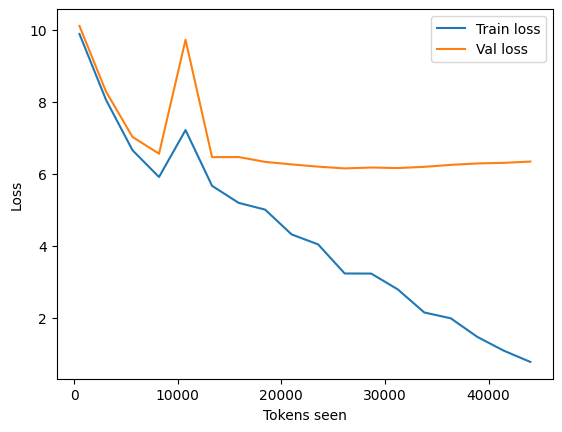

In [19]:
import matplotlib.pyplot as plt
plt.plot(tokens_seens, train_losses, label="Train loss")
plt.plot(tokens_seens, val_losses, label="Val loss")
plt.xlabel("Tokens seen")
plt.ylabel("Loss")
plt.legend()
plt.show()